# Plan:
* Prepare input with extracted UASTs
* Filter data from DB (if needed)
* Prepare pairs (provide specific requirements if needed)
* Statistics & visualization
* Export datasets

In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict, deque
from datetime import datetime
from glob import glob
import os
import sys

import bblfsh
from bblfsh import BblfshClient
from bblfsh.sdkversion import VERSION
import Levenshtein
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import text as plt_text
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size, udf
from pyspark.sql.types import BooleanType
import seaborn as sns
from sqlalchemy import Column, String, Float
from sqlalchemy.ext.declarative import declarative_base
from sqlite3 import connect
from tqdm import tqdm_notebook as tqdm

## Initialize pyspark session

In [3]:
os.environ["PYSPARK_PYTHON"] = "python3"

os.environ['PYSPARK_SUBMIT_ARGS'] = '--conf "spark.tech.sourced.bblfsh.grpc.host=bblfshd" ' \
                                    '--conf "spark.tech.sourced.engine.cleanup.skip=true" ' \
                                    '--driver-memory 90g ' \
                                    '--conf "spark.local.dir=/tmp/spark" ' \
                                    '--conf "spark.driver.maxResultSize=22048" pyspark-shell '

spark = SparkSession.builder.appName("near_duplicates_dataset").master("local[26]")
spark = spark.getOrCreate()

## Prepare input with extracted UASTs
### Expected parquet file with fields: [blob_id, repository_id, content, path, commit_hash, uast]

In [4]:
base_path = "/storage/egor/tmp/"
data_loc = base_path + "dataset_with_uasts_full/"
print("data_loc:", data_loc)

## Read dataset
data = spark.read.parquet(data_loc)
print("number of rows:", data.count())

## Deduplicate by blob_id
data = data.drop_duplicates(["blob_id"])
print("number of rows after deduplication of blob_id:", data.count())

data_loc: /storage/egor/tmp/dataset_with_uasts_full/
number of rows: 1545479
number of rows after deduplication of blob_id: 1012404


# Filter repositories and files to avoid duplications with DB

In [5]:
FILTER_REPOS = True
if FILTER_REPOS: 
    existing_db = base_path + "near_dupl_pairs/export_db/" + "2018-03-09T09_17_59Z-export.db"
    query = "select repository_id_a, repository_id_b from file_pairs;"
    ignore_repos = set()
    with connect(existing_db) as conn:
        repos_pairs = pd.read_sql_query(query, conn)
        ignore_repos.update(repos_pairs["repository_id_a"].tolist())
        ignore_repos.update(repos_pairs["repository_id_b"].tolist())
    print("number of repos to ignore:", len(ignore_repos))
    
    data = data[data.repository_id.isin(ignore_repos)== False]
    print("number of rows after filtering repos:", data.count())

number of repos to ignore: 723
number of rows after filtering repos: 854341


## Prepare pairs of similar files

In [6]:
def uast2sequence(root):
    # hack for broken uast iterator
    sequence = []
    nodes = defaultdict(deque)
    stack = [root]
    nodes[id(root)].extend(root.children)
    while stack:
        if nodes[id(stack[-1])]:
            child = nodes[id(stack[-1])].popleft()
            nodes[id(child)].extend(child.children)
            stack.append(child)
        else:
            sequence.append(stack.pop())
    return sequence


def flatten_uast(uast):
    seq = uast2sequence(uast)
    res = [item.internal_type for item in seq]
    return res


def uast_to_type_seq(uast):
    from bblfsh import Node
    return flatten_uast(Node.FromString(uast[0]))


def ratio_levenshtein(seq_a, seq_b):
    return Levenshtein.ratio(seq_a, seq_b)

    
def calc_uast_sim(uast_a, uast_b):
    type_seq_a = uast_to_type_seq(uast_a)
    type_seq_b = uast_to_type_seq(uast_b)
    
    res = ratio_levenshtein("".join(type_seq_a), "".join(type_seq_b))
    
    return res


def extract_pairs(dataframe, filter_res=None):
    if filter_res is None:
        filter_res = lambda *args, **kwargs: True
    elif not isinstance(filter_res, (list, tuple)):
        raise ValueError("Expected list or tuple of filtering functions, got %s" % type(filter_res))

    groups = dataframe.rdd.groupBy(lambda row: (row.repository_id, row.path))
    n_groups = groups.count()
    print("Number of groups:", n_groups)
    
    def _extract_pairs(group):
        key = group[0]  # skip
        rows = list(group[1])

        if len(rows) < 2:
            return
        indices = list(range(len(rows)))
        np.random.shuffle(indices)
        n_pairs = 0
        for a, b in zip(indices[:len(indices) // 2], indices[len(indices) // 2:]):
            row_a = rows[a].asDict()
            row_b = rows[b].asDict()
            ratio = ratio_levenshtein(row_a["content"].decode("utf-8", "ignore"),
                                      row_b["content"].decode("utf-8", "ignore"))
            uast_ratio = calc_uast_sim(row_a["uast"], row_b["uast"])
            if sum([fil(ratio, uast_ratio) for fil in filter_res]):
                yield row_a, row_b, ratio, uast_ratio
    return groups.flatMap(_extract_pairs)

## Sampling requirements

In [7]:
ranges = []
similarity_ranges = {"text_lower": 0.55,
                     "text_upper": 1.0,
                     "uast_lower": 0.45,
                     "uast_upper": 0.7}
ranges.append((similarity_ranges, 250))

similarity_ranges = {"text_lower": 0.55,
                     "text_upper": 0.7,
                     "uast_lower": 0.7,
                     "uast_upper": 1.}
ranges.append((similarity_ranges, 150))

similarity_ranges = {"text_lower": 0.3,
                     "text_upper": 0.55,
                     "uast_lower": 0.45,
                     "uast_upper": 1.}
ranges.append((similarity_ranges, 100))

def make_filter(sim_ranges):
    def filter_similarity(text_sim, uast_sim):
        return ((sim_ranges["text_lower"] <= text_sim <= sim_ranges["text_upper"]) and
                (sim_ranges["uast_lower"] <= uast_sim <= sim_ranges["uast_upper"]))
    return filter_similarity

## Select pairs that satisfy requirements above

In [8]:
filters = []
for sim_ranges, n_pairs in ranges:
    filters.append(make_filter(sim_ranges))

pairs = extract_pairs(data, filter_res=filters).cache()   
print("n_pairs extracted:", pairs.count())

all_pairs = pairs.collect()
xy = np.array([(row[2], row[3]) for row in all_pairs])

Number of groups: 781322
n_pairs extracted: 2950


## Statistics

In [22]:
pairs_blobs = set()
for pair in all_pairs:
    pairs_blobs.add(tuple(sorted((pair[0]["blob_id"], pair[0]["blob_id"]))))
print("number of unique blob id pairs:", len(pairs_blobs))

blobs = set()
for pair in all_pairs:
    blobs.add(pair[0]["blob_id"])
    blobs.add(pair[1]["blob_id"])
print("number of unique blob ids:", len(blobs))

number of unique blob id pairs: 2950
number of unique blob ids: 5900


### Lengths of texts

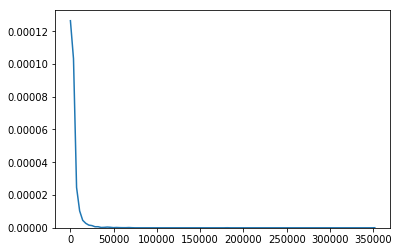

In [23]:
text_lengths = []
for pair in all_pairs:
    text_lengths.append(len(pair[0]["content"]))
    text_lengths.append(len(pair[1]["content"]))

sns.kdeplot(text_lengths, cut=0)

### Log lengths of texts

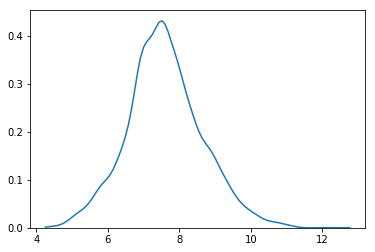

In [24]:
text_lengths = []
for pair in all_pairs:
    text_lengths.append(np.log(len(pair[0]["content"])))
    text_lengths.append(np.log(len(pair[1]["content"])))

sns.kdeplot(text_lengths, cut=0)

### Overall distribution

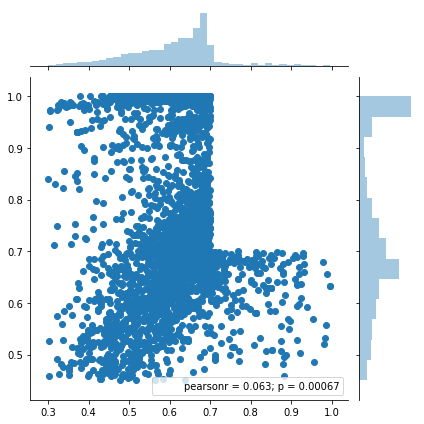

In [11]:
ax = sns.jointplot(x=xy[:, 0], y=xy[:, 1])

### Distribution with colorized length of texts

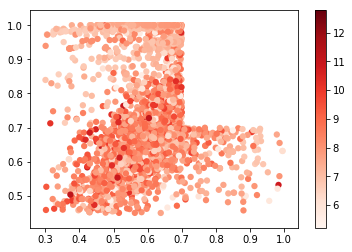

In [34]:
text_lengths = []
for pair in all_pairs:
    text_lengths.append(np.log(max(len(pair[0]["content"]), len(pair[1]["content"]))))

colors = text_lengths
mymap = plt.get_cmap("Reds")
my_colors = mymap(colors)
plt.scatter(xy[:, 0], xy[:, 1], s=40, c=colors, edgecolors='None', cmap=mymap)
plt.colorbar()

## Sampling
### Select samples based on `abs(uast_score - text_score)` - the higher the higher probability to select
### The reason to make random sampling instead of selecting samples with highest diff - it creates unused ares (see below)

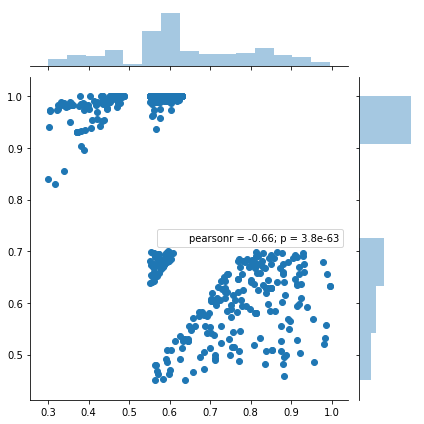

In [17]:
def dummy_sampler(similarity_ranges, xy):
    res = []
    for sim_range, n_samples in similarity_ranges:
        fil_xy = xy[(sim_range["text_lower"] <= xy[:, 0]) & (xy[:, 0] <= sim_range["text_upper"]) &
                    (sim_range["uast_lower"] <= xy[:, 1]) & (xy[:, 1] <= sim_range["uast_upper"])]
        
        # calculate pseudo probabilities based on distance
        diff = np.abs(fil_xy[:, 0] - fil_xy[:, 1])
        # select indicies
        ind = np.arange(fil_xy.shape[0])[np.argsort(diff)[-min(n_samples, fil_xy.shape[0]):]]
        xy_sample = fil_xy[ind]

        res.append(xy_sample)
    return np.vstack(res)

xy_final = dummy_sampler(ranges, xy)
ax = sns.jointplot(x=xy_final[:, 0], y=xy_final[:, 1])

### Proper random sampling

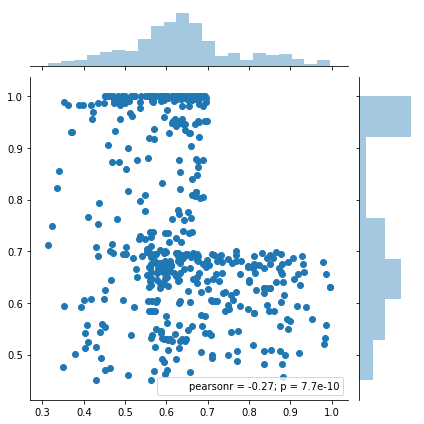

In [18]:
def sampler(similarity_ranges, xy):
    res = []
    input_ind = []
    for sim_range, n_samples in similarity_ranges:
        xy_ind = np.arange(xy.shape[0])[(sim_range["text_lower"] <= xy[:, 0]) &
                                        (xy[:, 0] <= sim_range["text_upper"]) &
                                        (sim_range["uast_lower"] <= xy[:, 1]) &
                                        (xy[:, 1] <= sim_range["uast_upper"])]
        fil_xy = xy[xy_ind]
        
        # calculate pseudo probabilities based on distance
        diff = np.abs(fil_xy[:, 0] - fil_xy[:, 1])
        probas = np.log(diff + 1) / np.log(diff + 1).sum()
        # select indicies
        ind = np.random.choice(np.arange(fil_xy.shape[0]), size=n_samples, p=probas, replace=False)
        input_ind.append(xy_ind[ind])
        xy_sample = fil_xy[ind]

        res.append(xy_sample)
    return np.vstack(res), np.hstack(input_ind)

xy_final, list_ind = sampler(ranges, xy)
ax = sns.jointplot(x=xy_final[:, 0], y=xy_final[:, 1])

In [36]:
similar_pairs = [all_pairs[i] for i in list_ind.astype(int).tolist()]
print("total number of pairs to keep:", len(similar_pairs))

total number of pairs to keep: 500


### Distribution with colorized length of texts

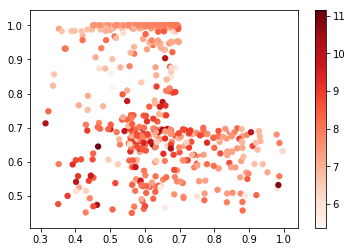

In [37]:
text_lengths = []
for pair in similar_pairs:
    text_lengths.append(np.log(max(len(pair[0]["content"]), len(pair[1]["content"]))))

colors = text_lengths
mymap = plt.get_cmap("Reds")
my_colors = mymap(colors)
plt.scatter(xy_final[:, 0], xy_final[:, 1], s=40, c=colors, edgecolors='None', cmap=mymap)
plt.colorbar()

## Add dummy features to pairs (we don't compute them now)

In [38]:
for pair in similar_pairs:
    pair[0]["bag"] = "no_features"
    pair[1]["bag"] = "no_features"

## Export dataset
### Pickle

In [40]:
import pickle
save_loc = base_path + "near_dupl_pairs/" + str(datetime.now().date()) + "_500_pairs.pkl"
with open(save_loc, "wb") as f:
    print("save similar pairs to", save_loc)
    pickle.dump(similar_pairs, f)

save similar pairs to /storage/egor/tmp/near_dupl_pairs/2018-03-10_500_pairs.pkl


### sqlite

In [41]:
Base = declarative_base()

fields = """blob_id_a TEXT, repository_id_a TEXT, commit_hash_a TEXT, path_a TEXT, content_a TEXT,
 blob_id_b TEXT, repository_id_b TEXT, commit_hash_b TEXT, path_b TEXT, content_b TEXT,
 score""".split()
fields = [field for field in fields if field != "TEXT,"]

start = "<Files("
end = "='%s')>"
repr_str = start + "='%s', ".join(fields) + end

class Files(Base):
    extend_existing=True
    __tablename__ = "files"
    blob_id_a = Column(String, primary_key=True)
    repository_id_a = Column(String)
    commit_hash_a = Column(String)
    path_a = Column(String)
    content_a = Column(String)
    blob_id_b = Column(String)
    repository_id_b = Column(String)
    commit_hash_b = Column(String)
    path_b = Column(String)
    content_b = Column(String)
    score = Column(Float(precision="DOUBLE"))
    def __repr__(self):
        return repr_str % (self.blob_id_a,
                           self.repository_id_a,
                           self.commit_hash_a,
                           self.path_a,
                           self.content_a,
                           self.blob_id_b,
                           self.repository_id_b,
                           self.commit_hash_b,
                           self.path_b,
                           self.content_b,
                           self.score)

In [42]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
 
# from https://www.pythoncentral.io/introductory-tutorial-python-sqlalchemy/
 
engine = create_engine("sqlite:///" + base_path + "near_dupl_pairs/" +
                       str(datetime.now().date()) + "_500_pairs.db")
Base.metadata.create_all(engine)
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)
session = DBSession()

for pair in similar_pairs:
    pair = Files(blob_id_a=pair[0]["blob_id"],
                 repository_id_a=pair[0]["repository_id"],
                 commit_hash_a=pair[0]["commit_hash"],
                 path_a=pair[0]["path"],
                 content_a=pair[0]["content"],
                 blob_id_b=pair[1]["blob_id"],
                 repository_id_b=pair[1]["repository_id"],
                 commit_hash_b=pair[1]["commit_hash"],
                 path_b=pair[1]["path"],
                 content_b=pair[1]["content"],
                 score=pair[2])
    session.add(pair)
    try:
        session.commit()
    except Exception as e:
        import pdb;pdb.set_trace()
        pass
                       